In [101]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")


Setup Complete


# **1- Regression discontinuity: banking recovery**

After a debt has been legally declared "uncollectable" by a bank, the account is considered to be "charged-off." But that doesn't mean the bank simply walks away from the debt. They still want to collect some of the money they are owed. The bank will score the account to assess the expected recovery amount, that is, the expected amount that the bank may be able to receive from the customer in the future (for a fixed time period such as one year). This amount is a function of the probability of the customer paying, the total debt, and other factors that impact the ability and willingness to pay.
The bank has implemented different recovery strategies at different thresholds (1000 usd, 2000, etc.) where the greater the expected recovery amount, the more effort the bank puts into contacting the customer. For low recovery amounts (Level 0), the bank just adds the customer's contact information to their automatic dialer and emailing system. For higher recovery strategies, the bank incurs more costs as they leverage human resources in more efforts to contact the customer and obtain payments. Each additional level of recovery strategy requires an additional 50 dollar per customer so that customers in the Recovery Strategy Level 1 cost the company 50 dollar more than those in Level 0. Customers in Level 2 cost 50 dollar more than those in Level 1, etc.
The big question: does the extra amount that is recovered at the higher strategy level exceed the extra 50 dollar in costs? In other words, was there a jump (also called a "discontinuity") of more than 50 dollar in the amount recovered at the higher strategy level?

- let us first load the data set and take a look at it

In [102]:
df = pd.read_csv("/kaggle/input/bank-debt-data/bank_data.csv")
df.head()


,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


# **2- Graphical exploratory data analysis**


The bank has implemented different recovery strategies at different thresholds (1000, 2000, 3000 and 5000) where the greater the Expected Recovery Amount, the more effort the bank puts into contacting the customer. Zeroing in on the first transition (between Level 0 and Level 1) means we are focused on the population with Expected Recovery Amounts between 0 and 2000 usd where the transition between Levels occurred at 1000 usd. We know that the customers in Level 1 (expected recovery amounts between 1001 and 2000) received more attention from the bank and, by definition, they had higher Expected Recovery Amounts than the customers in Level 0 (between 1 and 1000 usd).
Here's a quick summary of the Levels and thresholds again:
Level 0: Expected recovery amounts >0 and <=1000 usd
Level 1: Expected recovery amounts >1000 and <=2000 usd
The threshold of 1000 usd separates Level 0 from Level 1
A key question is whether there are other factors besides Expected Recovery Amount that also varied systematically across the 1000 usd threshold. For example, does the customer age show a jump (discontinuity) at the 1000 usd threshold or does that age vary smoothly? We can examine this by first making a scatter plot of the age as a function of Expected Recovery Amount for a small window of Expected Recovery Amount, 0 to 2000 usd. This range covers Levels 0 and 1.

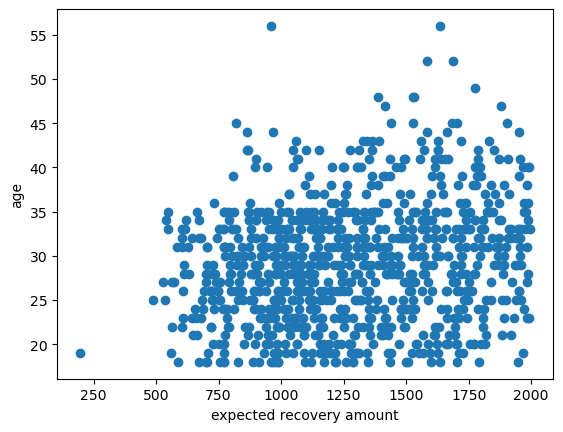

In [103]:
window_0_2000 = df[(df['expected_recovery_amount']>=0) & (df['expected_recovery_amount'] <=2000)]
plt.scatter(window_0_2000['expected_recovery_amount'] , window_0_2000['age'])
plt.xlabel('expected recovery amount')
plt.ylabel('age')
plt.show()

# **3 - Statistical test: age vs. expected recovery amount**

We want to convince ourselves that variables such as age and sex are similar above and below the 1000 dollar Expected Recovery Amount threshold. This is important because we want to be able to conclude that differences in the actual recovery amount are due to the higher Recovery Strategy and not due to some other difference like age or sex.
The scatter plot of age versus Expected Recovery Amount did not show an obvious jump around 1000 dollar. We will be more confident in our conclusions if we do statistical analysis examining the average age of the customers just above and just below the threshold. We can start by exploring the range from 900 to 1100 usd.

In [104]:
#first getting the average age of customers just above and just below the threshold
window_900_1100 = df.loc[ (df['expected_recovery_amount'] >=900) & (df['expected_recovery_amount'] <1100)]
by_recovery_strategy = window_900_1100.groupby(['recovery_strategy'])
#by_recovery_strategy.head()
by_recovery_strategy['age'].describe().unstack()

       recovery_strategy
count  Level 0 Recovery     89.000000
       Level 1 Recovery     94.000000
mean   Level 0 Recovery     27.224719
       Level 1 Recovery     28.755319
std    Level 0 Recovery      6.399135
       Level 1 Recovery      5.859807
min    Level 0 Recovery     18.000000
       Level 1 Recovery     18.000000
25%    Level 0 Recovery     23.000000
       Level 1 Recovery     24.000000
50%    Level 0 Recovery     26.000000
       Level 1 Recovery     29.000000
75%    Level 0 Recovery     31.000000
       Level 1 Recovery     33.000000
max    Level 0 Recovery     56.000000
       Level 1 Recovery     43.000000
dtype: float64

In [105]:
#performing a Kruskal-Wallis test
# .. to examine the average age of the customers just above and just below the threshold
from scipy import stats

Level_0_age = window_900_1100.loc[df['recovery_strategy']=="Level 0 Recovery"]['age']
Level_1_age = window_900_1100.loc[df['recovery_strategy']=="Level 1 Recovery"]['age']
stats.kruskal(Level_0_age,Level_1_age) 


KruskalResult(statistic=3.4572342749517513, pvalue=0.06297556896097407)

***since the p value is greater than 0.05 then we can conclude that there's no major jump in the average customer age just above and just below the 1000 threshold***

# **4- Statistical test: sex vs. expected recovery amount**

We were able to convince ourselves that there is no major jump in the average customer age just above and just below the 1000 threshold by doing a statistical test as well as exploring it graphically with a scatter plot.
We want to also test that the percentage of customers that are male does not jump as well across the 1000 threshold. We can start by exploring the range of 900 to 1100 and later adjust this range.

- we can perform a chi-squared test using the chi2_contingency function from Scipy to perform a chi-squared test and obtain the test statistic and p-value.

In [106]:
# N of male/female customers in each category
crosstab = pd.crosstab(df.loc[(df['expected_recovery_amount']<1100) & 
                              (df['expected_recovery_amount']>=900)]['recovery_strategy'], 
                       df['sex'])
print(crosstab)

# Chi-square test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
print(p_val)

sex                Female  Male
recovery_strategy              
Level 0 Recovery       32    57
Level 1 Recovery       39    55
0.5377947810444592


# **5- Exploratory graphical analysis: recovery amount**

We are now reasonably confident that customers just above and just below the 1000 threshold are, on average, similar in terms of their average age and the percentage that are male.
It is now time to focus on the key outcome of interest, the actual recovery amount.
A first step in examining the relationship between the actual recovery amount and the expected recovery amount is to develop a scatter plot where we want to focus our attention at the range just below and just above the threshold. Specifically, we will develop a scatter plot of Expected Recovery Amount (Y) vs. Actual Recovery Amount (X) for Expected Recovery Amounts between 900 to 1100. This range covers Levels 0 and 1. A key question is whether or not we see a discontinuity (jump) around the 1000 threshold.

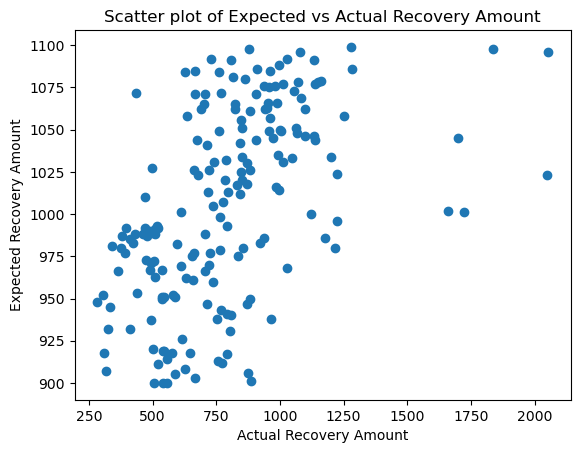

In [107]:
plt.scatter(window_900_1100['actual_recovery_amount'], window_900_1100['expected_recovery_amount'])
plt.xlabel('Actual Recovery Amount')
plt.ylabel('Expected Recovery Amount')
plt.title('Scatter plot of Expected vs Actual Recovery Amount')
plt.show()

# **6- Statistical analysis: recovery amount**

Just as we did with age, we can perform statistical tests to see if the actual recovery amount has a discontinuity above the 1000 threshold. We are going to do this for two different windows of the **expected recovery amount 900 to 1100** and **for a narrow range of 950 to 1050 to see if our results are consistent.**
Again, the statistical test we will use is the Kruskal-Wallis test, a test that makes no assumptions about the distribution of the actual recovery amount.

In [108]:
# Compute average actual recovery amount just below and above the threshold
by_recovery_strategy['actual_recovery_amount'].describe().unstack()

# Perform Kruskal-Wallis test on the first range from 900 to 1100
Level_0_actual = window_900_1100.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = window_900_1100.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
stats.kruskal(Level_0_actual,Level_1_actual) 
# Repeat for a smaller range of $950 to $1050
window_950_1050 = df.loc[(df['expected_recovery_amount']<1050) & 
                      (df['expected_recovery_amount']>=950)]
Level_0_actual = window_950_1050.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = window_950_1050.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']
stats.kruskal(Level_0_actual,Level_1_actual)

KruskalResult(statistic=30.246000000000038, pvalue=3.80575314300276e-08)

# **7- Regression modeling: no threshold**

We now want to take a regression-based approach to estimate the impact of the program at the 1000 threshold using the data that is just above and just below the threshold. In order to do that, we will build two models. The first model does not have a threshold while the second model will include a threshold.
The first model predicts the actual recovery amount (outcome or dependent variable) as a function of the expected recovery amount (input or independent variable). We expect that there will be a strong positive relationship between these two variables.

In [109]:
import statsmodels.api as sm

# Define X and y
X = window_900_1100['expected_recovery_amount']
y = window_900_1100['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Print out the model summary statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.261
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     63.78
Date:                    Fri, 21 Jul 2023   Prob (F-statistic):           1.56e-13
Time:                            15:29:49   Log-Likelihood:                -1278.9
No. Observations:                     183   AIC:                             2562.
Df Residuals:                         181   BIC:                             2568.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                    -1978.7597    347.741     -5.690      0.000   -2664.907   -1292.612
expected_recovery_amount     2.7577      0.345      7.986      0.000       2.076       3.439
==============================================================================
Omnibus:                       64.493   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              185.818
Skew:                           1.463   Prob(JB):                     4.47e-41
Kurtosis:                       6.977   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# **8- Regression modeling: adding true threshold**

From the first model, we see that the regression coefficient is statistically significant for the expected recovery amount and the adjusted R-squared value was about 0.26. As we saw from the graph, on average the actual recovery amount increases as the expected recovery amount increases. We could add polynomial terms of expected recovery amount (such as the squared value of expected recovery amount) to the model but, for the purposes of this practice, let's stick with using just the linear term.
The second model adds an indicator of the true threshold to the model. If there was no impact of the higher recovery strategy on the actual recovery amount, then we would expect that the relationship between the expected recovery amount and the actual recovery amount would be continuous.

In [113]:
#Create indicator (0 or 1) for expected recovery amount >= $1000
df['indicator_1000'] = np.where(df['expected_recovery_amount'] >=1000, 1, 0)

window_900_1100 = df.loc[(df['expected_recovery_amount']<1100) & 
                      (df['expected_recovery_amount']>=900)]

# Define X and y
X = window_900_1100[['expected_recovery_amount','indicator_1000']]
y = window_900_1100['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.314
Model:                                OLS   Adj. R-squared:                  0.307
Method:                     Least Squares   F-statistic:                     41.22
Date:                    Fri, 21 Jul 2023   Prob (F-statistic):           1.83e-15
Time:                            15:31:29   Log-Likelihood:                -1272.0
No. Observations:                     183   AIC:                             2550.
Df Residuals:                         180   BIC:                             2560.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        3.3440    626.274      0.005      0.996   -1232.440    1239.128
expected_recovery_amount     0.6430      0.655      0.981      0.328      -0.650       1.936
indicator_1000             277.6344     74.043      3.750      0.000     131.530     423.739
==============================================================================
Omnibus:                       65.977   Durbin-Watson:                   1.906
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.537
Skew:                           1.510   Prob(JB):                     3.12e-41
Kurtosis:                       6.917   Cond. No.                     3.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# **9- Regression modeling: adjusting the window**
The regression coefficient for the true threshold was statistically significant with an estimated impact of around 278 and a 95 percent confidence interval of 132 to 424. This is much larger than the incremental cost of running the higher recovery strategy which was 50 per customer. At this point, we are feeling reasonably confident that the higher recovery strategy is worth the additional costs of the program for customers just above and just below the threshold.
Before showing this to our managers, we want to convince ourselves that this result wasn't due just to us choosing a window of 900 to 1100 for the expected recovery amount. If the higher recovery strategy really had an impact of an extra few hundred dollars, then we should see a similar regression coefficient if we choose a slightly bigger or a slightly smaller window for the expected recovery amount. Let's repeat this analysis for the window of expected recovery amount from 950 to 1050 to see if we get similar results.

In [115]:
# Redefine era_950_1050 so the indicator variable is included
window_950_1050 = df.loc[(df['expected_recovery_amount']<1050) & 
                      (df['expected_recovery_amount']>=950)]

# Define X and y 
X = window_950_1050[['expected_recovery_amount','indicator_1000']]
y = window_950_1050['actual_recovery_amount']
X = sm.add_constant(X)

# Build linear regression model
model = sm.OLS(y,X).fit()

# Print the model summary
model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     actual_recovery_amount   R-squared:                       0.283
Model:                                OLS   Adj. R-squared:                  0.269
Method:                     Least Squares   F-statistic:                     18.99
Date:                    Fri, 21 Jul 2023   Prob (F-statistic):           1.12e-07
Time:                            15:37:17   Log-Likelihood:                -692.92
No. Observations:                      99   AIC:                             1392.
Df Residuals:                          96   BIC:                             1400.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     -279.5243   1840.707     -0.152      0.880   -3933.298    3374.250
expected_recovery_amount     0.9189      1.886      0.487      0.627      -2.825       4.663
indicator_1000             286.5337    111.352      2.573      0.012      65.502     507.566
==============================================================================
Omnibus:                       39.302   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.258
Skew:                           1.564   Prob(JB):                     1.37e-18
Kurtosis:                       6.186   Cond. No.                     6.81e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""